## Importing Libraries

In [1]:
import numpy as np # Numpy is the building block of the other libraries we will use
import cv2 #Open CV is used for image processing 
from sklearn.cluster import KMeans 
# The un-supervised algorithm we will use to to cluster the pixel data based on the RBG values
from collections import Counter #This library is useful for counting labels 
import imutils # This library is useful for image processing 
import pprint # This library is useful for pretty printing data 
import matplotlib.pyplot as plt # This is a useful graph plotting library 


## Take Image From Computer Webcam

In [11]:
### This will take a screenshot of the face 
cap = cv2.VideoCapture(0) # Most webcams require the number 0, but it is a number that will have to be tested for various computers can range from (0,10)


while(True):
    ret,frame = cap.read() # return a single frame in variable 'frame'
    cv2.imshow('img1',frame) # display the captured image
    
    if cv2.waitKey(1) & 0xFF == ord('y'): # It will take and save the Image by Pressing on 'Y' on keyboard 
        cv2.imwrite('face.png',frame) #This will save the image as face.png in the images folder
        cv2.destroyAllWindows()
        break

cap.release() 
cv2.destroyAllWindows()
for i in range(1,5): # This will shut down the frame properly 
    cv2.waitKey(1)
### screenshot saved in folder

In [4]:
image = cv2.imread('Images/face.png')

In [6]:
min_HSV = np.array([0, 48, 30], dtype = "uint8")
max_HSV = np.array([33, 255, 255], dtype = "uint8")
# Get pointer to video frames from primary device
image = cv2.imread("Images/face.png")
imageHSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
skinRegionHSV = cv2.inRange(imageHSV, min_HSV, max_HSV)

skinHSV = cv2.bitwise_and(image, image, mask = skinRegionHSV)

cv2.imwrite("faceshot.png", np.hstack([image, skinHSV]))

True

In [7]:
def extractSkin(image):
    # Taking a copy of the image
    #img = image.copy()
    # Converting from BGR Colours Space to HSV 
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [8]:
def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

In [9]:
def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation

In [10]:
def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

In [11]:
def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar

In [12]:
def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()

In [13]:
# resize the image to a width of 250
image = imutils.resize(image, width=250)

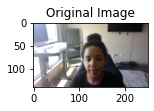

In [14]:
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show();

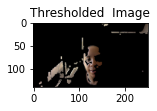

In [15]:

# Apply Skin Mask

skin = extractSkin(image)


plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
plt.show();

In [16]:
# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

In [17]:
# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

Color Information
{'cluster_index': 1,
 'color': [79.49740932642526, 52.61554404145067, 39.354404145077694],
 'color_percentage': 0.24993511549441993}

{'cluster_index': 0,
 'color': [138.72085561497292, 120.17219251336886, 107.72727272727215],
 'color_percentage': 0.24344666493641318}

{'cluster_index': 3,
 'color': [107.77133105802096, 88.50284414106929, 76.91695108077323],
 'color_percentage': 0.2286529976641578}

{'cluster_index': 4,
 'color': [178.03780068728452, 159.20504009163793, 143.6368843069868],
 'color_percentage': 0.2260576174409551}

{'cluster_index': 2,
 'color': [225.74129353233874, 210.3283582089551, 194.8358208955219],
 'color_percentage': 0.051907604464053986}



Color Bar


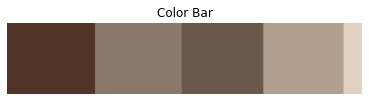

In [18]:
# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()

In [19]:
example = dominantColors[0]['color']
example

[79.49740932642526, 52.61554404145067, 39.354404145077694]

In [20]:
def dominantColors(image):
    skin = extractSkin(image)
    skincolor = extractDominantColor(skin, hasThresholding=True)
    return skincolor

In [21]:
dominantColors(image)

[{'cluster_index': 1,
  'color': [79.49740932642527, 52.61554404145067, 39.354404145077694],
  'color_percentage': 0.24993511549441993},
 {'cluster_index': 0,
  'color': [138.72085561497292, 120.17219251336887, 107.72727272727215],
  'color_percentage': 0.24344666493641318},
 {'cluster_index': 3,
  'color': [107.77133105802096, 88.50284414106929, 76.91695108077325],
  'color_percentage': 0.2286529976641578},
 {'cluster_index': 4,
  'color': [178.0378006872845, 159.20504009163793, 143.6368843069868],
  'color_percentage': 0.2260576174409551},
 {'cluster_index': 2,
  'color': [225.74129353233874, 210.3283582089551, 194.8358208955219],
  'color_percentage': 0.051907604464053986}]

# Pickling our Model to use in the App

In [24]:
import pickle
import joblib as joblib

In [25]:
filename = 'skin_model.sav'
joblib.dump(extractDominantColor, filename)

['skin_model.sav']

In [26]:
image=cv2.imread("Images/rihanna.jpeg")

In [27]:
loaded_model = joblib.load(filename)
result = loaded_model(image)
print(result)

[{'cluster_index': 0, 'color': [28.128508124080973, 76.48478581979056, 104.06646971934973], 'color_percentage': 0.5380625931445604}, {'cluster_index': 1, 'color': [240.31455989930856, 149.1442617792769, 98.10980885707521], 'color_percentage': 0.2523397913561848}, {'cluster_index': 3, 'color': [16.850704934543558, 15.811430010067923, 19.09290030211598], 'color_percentage': 0.07890710382513662}, {'cluster_index': 4, 'color': [64.89361118727685, 119.4069097888672, 147.9640800658074], 'color_percentage': 0.07252856433184302}, {'cluster_index': 2, 'color': [171.9107449364929, 101.00240302094055, 64.11122554067938], 'color_percentage': 0.058161947342275214}]


In [28]:
dominantColors(image)

[{'cluster_index': 2,
  'color': [248.48051466039203, 152.20747247308964, 97.50600024742815],
  'color_percentage': 0.506963092487354},
 {'cluster_index': 4,
  'color': [223.16882773220004, 129.82640910293748, 80.69568668959982],
  'color_percentage': 0.23449697121089116},
 {'cluster_index': 3,
  'color': [172.85827216261956, 103.64370412196467, 67.85036702427996],
  'color_percentage': 0.10984824829825766},
 {'cluster_index': 0,
  'color': [225.4619640387274, 163.31604426002735, 129.0428769017978],
  'color_percentage': 0.09055142696559046},
 {'cluster_index': 1,
  'color': [105.78479657387592, 64.91220556745171, 44.588865096359676],
  'color_percentage': 0.058140261037906704}]

In [29]:
print(image)

[[[ 97  76  31]
  [ 97  76  31]
  [ 97  76  31]
  ...
  [ 95  77  30]
  [ 95  77  30]
  [ 95  77  30]]

 [[ 98  77  32]
  [ 98  77  32]
  [ 98  77  32]
  ...
  [ 96  78  31]
  [ 96  78  31]
  [ 96  78  31]]

 [[ 98  77  32]
  [ 98  77  32]
  [ 98  77  32]
  ...
  [ 96  77  32]
  [ 96  77  32]
  [ 96  77  32]]

 ...

 [[165 138  82]
  [165 138  82]
  [166 139  83]
  ...
  [111  90  52]
  [111  91  50]
  [111  91  50]]

 [[165 138  82]
  [165 138  82]
  [166 139  83]
  ...
  [111  90  52]
  [111  91  50]
  [111  91  50]]

 [[165 138  82]
  [165 138  82]
  [166 139  83]
  ...
  [111  90  52]
  [111  91  50]
  [111  91  50]]]
